# Week 7: OLS for non-linear relationships

## By Charlie Eaton

Note for writing formulas: here is an awesome wiki dictionary for LaTex code for math symbols: https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols

## OLS Non-linear relationships:

1. are nominal/categorical (dummy variables)

2. change in increments (sequential dummy variables)

3. change direction or strength abruptly (spline)

4. change direction gradually (quadratic)

5. accelerate/decelerate -- i.e. curve (logarithmic)

## Do the usual to check out the data

In [ ]:
%set graph_format svg

In [ ]:
qui set more off
qui capture log close
qui log using w7lesson_log20200304.log
qui use realrinc age sex race educ yearsjob paeduc PASEI10 using GSS2018w7.dta, clear
*describe
*summarize realrinc age sex race educ yearsjob paeduc

## 1. Nominal dummy variables

Creates "0" and "1" indicator variables for each category of a nominal variable.

Add the two nominal variables in our dataset to the code below to create dummy variables for each.

In [ ]:
xi i.[var1] i.[var2], noomit

In [ ]:
%head sex race _I* if _n<6

### Specify which category to omit in regression

Change the number in the stub of each nominal variable below to specify omitted categories

In [ ]:
xi: reg realrinc ib1.sex ib1.race

### A nice graphical way to represent dummy estimates is OLS adjusted means

These are the estimated mean for a category if all other variables are estimated as held constant

In [ ]:
margins i.[VAR], atmeans
*marginsplot
*marginsplot, horizontal unique recast(scatter) ytitle(estimated income)

## 2. Recoding continuous variables to sequential dummies

This is a good tool when interval ratio relationships change direction or slope (i.e. are non-linear)

For example, student debt (DV) and parental income (IV) have a non-linear relationship (Houle 2014):

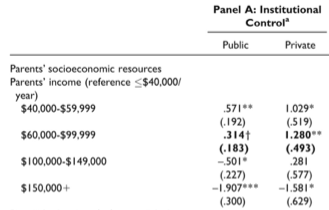

### What about modeling income (DV) and age (IV)?

### Is it linear?

In [ ]:
tw (scatter realrinc age, sort) (lfit realrinc age, color(red) lwidth(thick)), legend(off) name(linear, replace)

### Convert age to sequential dummy variables to check

First, recode age as age brackets

In [ ]:
drop agecat
egen agecat = cut(age), at(18,30,40,50,60,70,90)
tab agecat

### Then regress income on age categories as dummies

In [ ]:
qui xi: reg realrinc ib18.agecat
qui margins i.agecat, atmeans
marginsplot,  unique recast(scatter) ytitle(estimated income)

## 3. Splines measure slopes of interval-ratio relationships that change

*These measure the linear relationship for ranges of the IV.

*This enables us to test changes at discrete breaking points.

*ages1 for age-spline1 is set to the age for everyone under 50 and 50 for everyone above 50
ages2 is set to the age minus 50 for everyone above 50 and 0 for everyone else

In [ ]:
*Create two spline vars with a "Knot" at age 50
mkspline ages1 50 ages2 = age

*Look at the distribution of values for the two spline vars with histogram
histogram ages1
histogram ages2

*OLS estimate the slope for age above and below 50 and predict y values
regress realrinc ages1 ages2
predict yhat

*Graph the fited spline lines for ages above and below 50
tw (scatter realrinc age) (line yhat age, sort color(red) lwidth(thick))

## 4. Quadratics: when interval ratio relationships gradually change direction

* For example the relationship between income (DV) and age (IV)
* The solution is to square the IV (age) and add it to the model:

$ \hat{Y} = \alpha + \beta_1 \cdot X + \beta_2 \cdot X^2 $

### Let's compare age coefficients with and w/o a quadratic

Complete the code below to create a squared age variable

In [ ]:
qui est clear

*Model 1 - no quadritic
qui eststo: regress realrinc age

*Model 2 - quadratic added
gen age2=[YOUR CODE HERE]
qui eststo: regress realrinc age age2

**Print a table with the two models
esttab, stats(r2 N, labels("R-Sqaured" "N")) cells(b(star fmt(3)) ///
se(fmt(3) par)) nobase

### Also graph the quadratic and compare

In [ ]:
qui tw (scatter realrinc age, sort) ///
(lfit realrinc age, color(red) lwidth(thick))
(qfit realrinc age, color(green) lwidth(thick)), ///
legend(off) name(quadratic, replace)

## 5. Logarithms: model when interval ratio relationships accelerate/decelerate (curve)

### You can log dependent or independent or dependent variables

*Some relationships curve, like with income (DV) and education/human capital investment (IV)

*Logs are the opposites of exponents like $X^3$

*Definition of (natural) logarithm: The exponent to which a another number (e=2.718... for natural logs) must be raised to produce X, Y, or any other given number. (e=2.718... is an irrational and transcendental number like $\pi$)

$Z = ln(X)$ if $X = 10^Z$

*When graphed, the natural log function looks like this:

In [ ]:
tw (function Z = log(x), range(0 20))

**When X is less than 1 (like ..5), Z is negative

We can reverse engineer this:

In [ ]:
display "if Z=-2, X = 10^Z = 10^-2 = 1/10 * 1/10 = " 1/2.718 * 1/2.718
display "if X=.135, Z= ln(X) = ln(.135) = "log(.135)

display "if Z=2, X = 10^Z = 10^2 = "10^2
display "if X=[??], Z= ln(X) = ln([??]) =" log(??)

### A magical feature of logs:

Logs approximate proportional change in the number that is logged for proportional chances less than .2 (20%).

For example:

In [ ]:
display "e^b = Proportional Change in X = X2/X1 = (110/100) = " 110/100
display "beta = ln(e^b) = nl(X2/X1) = nl(110/100) = " = log(11/10)

### Let's apply this to income (DV) and education (IV)

*First, create a new variable that logs income

*Then regress the unlogged and logged income variable (DV) on education (IV) and compare

*Which estimates are better and why? What is the proportional increase for income for every year of education?

In [ ]:
**Create a logged income variable
*gen realrinc_ln=log([EXISTING VARNAME HERE])
drop yhat yhatln
qui est clear

**Regress w/o logging
qui eststo: reg realrinc educ

** Predict Y-hat based on the above regression
qui predict yhat, xb

**Regress logged Y on education
qui eststo: reg realrinc_ln educ

** Predict logged Y-hat based on the above regression
predict yhatln

**Then exponentiate 
replace yhatln=2.718^(yhatln)

**Print estimates from both models
esttab, stats(r2 N, labels("R-Sqaured" "N")) cells(b(star fmt(3)) ///
se(fmt(3) par)) nobase

### The logged results can be more intuitive when graphed

In [ ]:
**Create a scatterplot of income and education
**with fitted linear regression line and fitted logged regression line
tw (scatter realrinc educ) ///
(line yhat educ, sort color(red) lwidth(thick)) ///
(line yhatln educ, sort color(blue) lwidth(thick)), legend(off)

You may want to run correlation analysis to see the linear relationship among variables